# Classification on Botnet DGA Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [3]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-41/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-41/


## Example of a QNode

In [4]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [5]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [6]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [7]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [8]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [10]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [11]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [12]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [13]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [16]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [17]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmp7s7aenl_/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [18]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 465s 36s/step - loss: 0.7003 - tp: 50.3571 - fp: 19.7857 - tn: 170.7143 - fn: 129.0000 - accuracy: 0.5976 - precision: 0.7079 - recall: 0.2671 - auc: 0.5434 - val_loss: 0.7365 - val_tp: 8.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 78.0000 - val_accuracy: 0.4654 - val_precision: 0.5333 - val_recall: 0.0930 - val_auc: 0.2634
Epoch 2/10000
13/13 [==============================] - 472s 36s/step - loss: 0.7072 - tp: 51.7143 - fp: 22.8571 - tn: 169.0714 - fn: 126.2143 - accuracy: 0.6068 - precision: 0.6952 - recall: 0.3013 - auc: 0.5376 - val_loss: 0.7313 - val_tp: 6.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 80.0000 - val_accuracy: 0.4528 - val_precision: 0.4615 - val_recall: 0.0698 - val_auc: 0.2788
Epoch 3/10000
13/13 [==============================] - 473s 36s/step - loss: 0.7104 - tp: 37.6429 - fp: 14.5714 - tn: 179.2143 - fn: 138.4286 - accuracy: 0.5931 - precision: 0.7040 - recall: 0.2115 - auc: 0.5230 - val_loss: 0.

13/13 [==============================] - 477s 37s/step - loss: 0.6230 - tp: 64.3571 - fp: 7.5000 - tn: 184.2857 - fn: 113.7143 - accuracy: 0.6639 - precision: 0.9057 - recall: 0.3339 - auc: 0.7338 - val_loss: 0.6202 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.8310
Epoch 44/10000
13/13 [==============================] - 475s 37s/step - loss: 0.5991 - tp: 74.5000 - fp: 11.5000 - tn: 181.7857 - fn: 102.0714 - accuracy: 0.6970 - precision: 0.8455 - recall: 0.4316 - auc: 0.7604 - val_loss: 0.6154 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.8571
Epoch 45/10000
13/13 [==============================] - 477s 37s/step - loss: 0.6180 - tp: 76.8571 - fp: 11.5714 - tn: 179.7143 - fn: 101.7143 - accuracy: 0.6896 - precision: 0.8650 - recall: 0.4270 - auc: 0.7326 - val_loss: 0.6184 - val_

13/13 [==============================] - 477s 37s/step - loss: 0.5767 - tp: 82.5000 - fp: 8.8571 - tn: 184.7857 - fn: 93.7143 - accuracy: 0.7187 - precision: 0.9051 - recall: 0.4480 - auc: 0.7415 - val_loss: 0.5707 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8538
Epoch 86/10000
13/13 [==============================] - 478s 37s/step - loss: 0.5637 - tp: 93.6429 - fp: 8.2857 - tn: 177.6429 - fn: 90.2857 - accuracy: 0.7306 - precision: 0.9205 - recall: 0.5089 - auc: 0.7813 - val_loss: 0.5691 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8678
Epoch 87/10000
13/13 [==============================] - 478s 37s/step - loss: 0.5826 - tp: 80.3571 - fp: 10.1429 - tn: 179.5000 - fn: 99.8571 - accuracy: 0.7061 - precision: 0.8797 - recall: 0.4651 - auc: 0.7368 - val_loss: 0.5679 - val_tp: 

13/13 [==============================] - 478s 37s/step - loss: 0.5577 - tp: 94.1429 - fp: 13.3571 - tn: 173.3571 - fn: 89.0000 - accuracy: 0.7306 - precision: 0.8838 - recall: 0.5364 - auc: 0.7652 - val_loss: 0.5460 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8515
Epoch 128/10000
13/13 [==============================] - 478s 37s/step - loss: 0.5556 - tp: 91.6429 - fp: 11.6429 - tn: 178.6429 - fn: 87.9286 - accuracy: 0.7264 - precision: 0.8878 - recall: 0.5090 - auc: 0.7759 - val_loss: 0.5435 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8603
Epoch 129/10000
13/13 [==============================] - 478s 37s/step - loss: 0.5598 - tp: 92.2143 - fp: 8.9286 - tn: 175.5714 - fn: 93.1429 - accuracy: 0.7216 - precision: 0.9238 - recall: 0.5004 - auc: 0.7632 - val_loss: 0.5422 - val_t

13/13 [==============================] - 478s 37s/step - loss: 0.5374 - tp: 98.8571 - fp: 7.8571 - tn: 183.1429 - fn: 80.0000 - accuracy: 0.7610 - precision: 0.9377 - recall: 0.5484 - auc: 0.7881 - val_loss: 0.5283 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.8831
Epoch 170/10000
13/13 [==============================] - 479s 37s/step - loss: 0.5315 - tp: 99.1429 - fp: 11.1429 - tn: 183.2143 - fn: 76.3571 - accuracy: 0.7589 - precision: 0.8803 - recall: 0.5594 - auc: 0.7597 - val_loss: 0.5228 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.8958
Epoch 171/10000
13/13 [==============================] - 479s 37s/step - loss: 0.5026 - tp: 98.5714 - fp: 7.0000 - tn: 187.5000 - fn: 76.7857 - accuracy: 0.7823 - precision: 0.9334 - recall: 0.5808 - auc: 0.7905 - val_loss: 0.5273 - val_tp

13/13 [==============================] - 479s 37s/step - loss: 0.5055 - tp: 102.5714 - fp: 2.7143 - tn: 188.4286 - fn: 76.1429 - accuracy: 0.7795 - precision: 0.9790 - recall: 0.5555 - auc: 0.7948 - val_loss: 0.5165 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9129
Epoch 212/10000
13/13 [==============================] - 479s 37s/step - loss: 0.5295 - tp: 97.0000 - fp: 14.3571 - tn: 179.0714 - fn: 79.4286 - accuracy: 0.7510 - precision: 0.8772 - recall: 0.5599 - auc: 0.7577 - val_loss: 0.5159 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9200
Epoch 213/10000
13/13 [==============================] - 479s 37s/step - loss: 0.5206 - tp: 106.8571 - fp: 10.9286 - tn: 180.3571 - fn: 71.7143 - accuracy: 0.7711 - precision: 0.9005 - recall: 0.5849 - auc: 0.7703 - val_loss: 0.5108 - val

13/13 [==============================] - 478s 37s/step - loss: 0.4931 - tp: 103.6429 - fp: 7.1429 - tn: 186.6429 - fn: 72.4286 - accuracy: 0.7855 - precision: 0.9278 - recall: 0.5891 - auc: 0.7943 - val_loss: 0.5069 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9403
Epoch 254/10000
13/13 [==============================] - 479s 37s/step - loss: 0.4754 - tp: 113.7857 - fp: 8.2143 - tn: 181.7143 - fn: 66.1429 - accuracy: 0.8027 - precision: 0.9317 - recall: 0.6341 - auc: 0.7947 - val_loss: 0.5062 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9299
Epoch 255/10000
13/13 [==============================] - 479s 37s/step - loss: 0.4713 - tp: 112.2143 - fp: 7.4286 - tn: 182.1429 - fn: 68.0714 - accuracy: 0.7993 - precision: 0.9397 - recall: 0.6266 - auc: 0.8188 - val_loss: 0.5024 - val_

13/13 [==============================] - 456s 35s/step - loss: 0.4813 - tp: 112.0714 - fp: 10.2857 - tn: 178.8571 - fn: 68.6429 - accuracy: 0.7902 - precision: 0.9105 - recall: 0.6298 - auc: 0.8183 - val_loss: 0.4949 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9325
Epoch 296/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4842 - tp: 114.3571 - fp: 10.6429 - tn: 180.6429 - fn: 64.2143 - accuracy: 0.7932 - precision: 0.9097 - recall: 0.6376 - auc: 0.8214 - val_loss: 0.4970 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9343
Epoch 297/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4779 - tp: 108.2143 - fp: 7.2857 - tn: 185.2857 - fn: 69.0714 - accuracy: 0.7936 - precision: 0.9412 - recall: 0.6104 - auc: 0.7881 - val_loss: 0.4946 - va

13/13 [==============================] - 457s 35s/step - loss: 0.5117 - tp: 97.5714 - fp: 8.4286 - tn: 191.5000 - fn: 72.3571 - accuracy: 0.7780 - precision: 0.9110 - recall: 0.5642 - auc: 0.7241 - val_loss: 0.4937 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9433
Epoch 338/10000
13/13 [==============================] - 458s 35s/step - loss: 0.5048 - tp: 97.5000 - fp: 7.0000 - tn: 189.4286 - fn: 75.9286 - accuracy: 0.7802 - precision: 0.9384 - recall: 0.5584 - auc: 0.7502 - val_loss: 0.4891 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9439
Epoch 339/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4911 - tp: 113.2857 - fp: 9.3571 - tn: 179.2857 - fn: 67.9286 - accuracy: 0.7811 - precision: 0.9318 - recall: 0.6119 - auc: 0.7859 - val_loss: 0.4855 - val_tp

13/13 [==============================] - 457s 35s/step - loss: 0.4804 - tp: 109.7143 - fp: 4.3571 - tn: 187.7857 - fn: 68.0000 - accuracy: 0.8046 - precision: 0.9636 - recall: 0.6215 - auc: 0.7724 - val_loss: 0.4848 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9403
Epoch 380/10000
13/13 [==============================] - 457s 35s/step - loss: 0.5003 - tp: 99.7143 - fp: 7.9286 - tn: 186.6429 - fn: 75.5714 - accuracy: 0.7711 - precision: 0.9129 - recall: 0.5673 - auc: 0.7795 - val_loss: 0.4889 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9302
Epoch 381/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4545 - tp: 110.9286 - fp: 5.0000 - tn: 189.1429 - fn: 64.7857 - accuracy: 0.8118 - precision: 0.9542 - recall: 0.6376 - auc: 0.8036 - val_loss: 0.4866 - val_t

13/13 [==============================] - 457s 35s/step - loss: 0.4648 - tp: 109.0714 - fp: 4.5000 - tn: 190.3571 - fn: 65.9286 - accuracy: 0.8156 - precision: 0.9625 - recall: 0.6285 - auc: 0.7908 - val_loss: 0.4827 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9460
Epoch 422/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4840 - tp: 111.0000 - fp: 8.5714 - tn: 183.4286 - fn: 66.8571 - accuracy: 0.7884 - precision: 0.9069 - recall: 0.6140 - auc: 0.7864 - val_loss: 0.4790 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9461
Epoch 423/10000
13/13 [==============================] - 457s 35s/step - loss: 0.5277 - tp: 101.2143 - fp: 7.0000 - tn: 176.6429 - fn: 85.0000 - accuracy: 0.7366 - precision: 0.9282 - recall: 0.5353 - auc: 0.7739 - val_loss: 0.4759 - val_

13/13 [==============================] - 457s 35s/step - loss: 0.4824 - tp: 98.8571 - fp: 4.0000 - tn: 188.2857 - fn: 78.7143 - accuracy: 0.7821 - precision: 0.9662 - recall: 0.5667 - auc: 0.7753 - val_loss: 0.4722 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9420
Epoch 464/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4809 - tp: 107.5714 - fp: 7.0000 - tn: 181.5714 - fn: 73.7143 - accuracy: 0.7865 - precision: 0.9468 - recall: 0.5986 - auc: 0.7855 - val_loss: 0.4729 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9395
Epoch 465/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4386 - tp: 116.1429 - fp: 7.4286 - tn: 186.1429 - fn: 60.1429 - accuracy: 0.8213 - precision: 0.9383 - recall: 0.6623 - auc: 0.8342 - val_loss: 0.4728 - val_t

13/13 [==============================] - 458s 35s/step - loss: 0.4941 - tp: 112.0000 - fp: 4.7857 - tn: 178.8571 - fn: 74.2143 - accuracy: 0.7724 - precision: 0.9545 - recall: 0.5931 - auc: 0.7714 - val_loss: 0.4696 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9475
Epoch 506/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4688 - tp: 112.7857 - fp: 6.3571 - tn: 183.9286 - fn: 66.7857 - accuracy: 0.7999 - precision: 0.9442 - recall: 0.6123 - auc: 0.7864 - val_loss: 0.4693 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9405
Epoch 507/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4682 - tp: 108.5714 - fp: 9.8571 - tn: 183.6429 - fn: 67.7857 - accuracy: 0.7873 - precision: 0.9115 - recall: 0.6033 - auc: 0.8346 - val_loss: 0.4735 - val_

13/13 [==============================] - 457s 35s/step - loss: 0.4581 - tp: 118.9286 - fp: 9.0000 - tn: 181.5000 - fn: 60.4286 - accuracy: 0.8092 - precision: 0.9293 - recall: 0.6623 - auc: 0.8248 - val_loss: 0.4643 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9505
Epoch 548/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4453 - tp: 111.9286 - fp: 8.6429 - tn: 185.6429 - fn: 63.6429 - accuracy: 0.8161 - precision: 0.9315 - recall: 0.6586 - auc: 0.8140 - val_loss: 0.4662 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9520
Epoch 549/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4915 - tp: 108.8571 - fp: 7.3571 - tn: 180.4286 - fn: 73.2143 - accuracy: 0.7744 - precision: 0.9351 - recall: 0.5775 - auc: 0.7452 - val_loss: 0.4673 - val_

13/13 [==============================] - 458s 35s/step - loss: 0.4584 - tp: 110.6429 - fp: 5.2143 - tn: 189.5714 - fn: 64.4286 - accuracy: 0.8108 - precision: 0.9616 - recall: 0.6117 - auc: 0.8035 - val_loss: 0.4610 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9360
Epoch 590/10000
13/13 [==============================] - 457s 35s/step - loss: 0.4766 - tp: 112.3571 - fp: 8.6429 - tn: 177.7857 - fn: 71.0714 - accuracy: 0.7925 - precision: 0.9367 - recall: 0.6253 - auc: 0.7978 - val_loss: 0.4620 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9451
Epoch 591/10000
13/13 [==============================] - 459s 35s/step - loss: 0.4435 - tp: 110.7857 - fp: 3.2143 - tn: 191.3571 - fn: 64.5000 - accuracy: 0.8210 - precision: 0.9804 - recall: 0.6347 - auc: 0.7830 - val_loss: 0.4618 - val_

13/13 [==============================] - 459s 35s/step - loss: 0.5008 - tp: 105.5000 - fp: 6.2857 - tn: 186.0000 - fn: 72.0714 - accuracy: 0.7881 - precision: 0.9418 - recall: 0.5905 - auc: 0.7473 - val_loss: 0.4562 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9454
Epoch 632/10000
13/13 [==============================] - 459s 35s/step - loss: 0.4672 - tp: 105.7857 - fp: 4.8571 - tn: 188.8571 - fn: 70.3571 - accuracy: 0.8020 - precision: 0.9599 - recall: 0.6045 - auc: 0.7901 - val_loss: 0.4549 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9496
Epoch 633/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4345 - tp: 120.5714 - fp: 5.2857 - tn: 184.8571 - fn: 59.1429 - accuracy: 0.8270 - precision: 0.9624 - recall: 0.6791 - auc: 0.8210 - val_loss: 0.4605 - val_

13/13 [==============================] - 457s 35s/step - loss: 0.5008 - tp: 107.0714 - fp: 4.7857 - tn: 179.5000 - fn: 78.5000 - accuracy: 0.7678 - precision: 0.9598 - recall: 0.5757 - auc: 0.7475 - val_loss: 0.4564 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9493
Epoch 674/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4340 - tp: 114.9286 - fp: 6.2143 - tn: 187.8571 - fn: 60.8571 - accuracy: 0.8248 - precision: 0.9556 - recall: 0.6557 - auc: 0.8231 - val_loss: 0.4536 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9505
Epoch 675/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4315 - tp: 112.0000 - fp: 7.4286 - tn: 191.5714 - fn: 58.8571 - accuracy: 0.8294 - precision: 0.9357 - recall: 0.6679 - auc: 0.8380 - val_loss: 0.4588 - val_

13/13 [==============================] - 458s 35s/step - loss: 0.4253 - tp: 118.2857 - fp: 7.5714 - tn: 183.5000 - fn: 60.5000 - accuracy: 0.8227 - precision: 0.9498 - recall: 0.6709 - auc: 0.8309 - val_loss: 0.4577 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9472
Epoch 716/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4466 - tp: 115.0714 - fp: 10.0000 - tn: 180.0000 - fn: 64.7857 - accuracy: 0.8002 - precision: 0.9156 - recall: 0.6508 - auc: 0.8247 - val_loss: 0.4561 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9497
Epoch 717/10000
13/13 [==============================] - 458s 35s/step - loss: 0.4787 - tp: 105.4286 - fp: 8.3571 - tn: 186.9286 - fn: 69.1429 - accuracy: 0.7852 - precision: 0.9307 - recall: 0.5928 - auc: 0.7904 - val_loss: 0.4563 - val

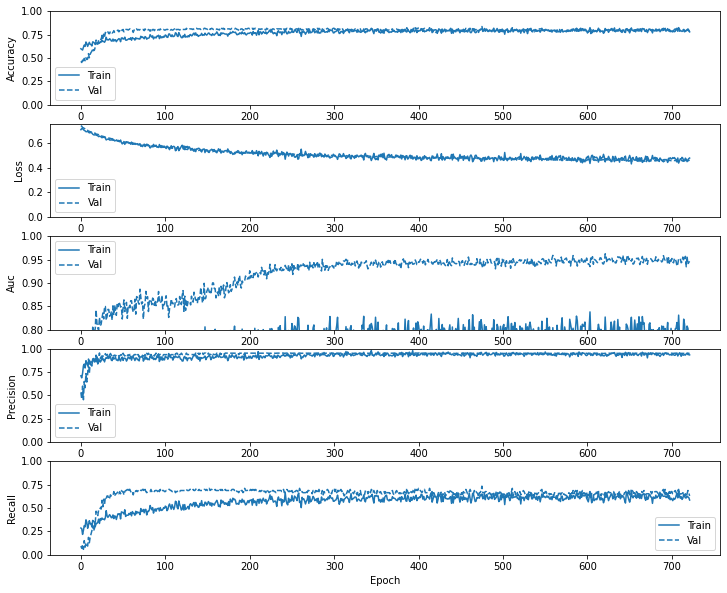

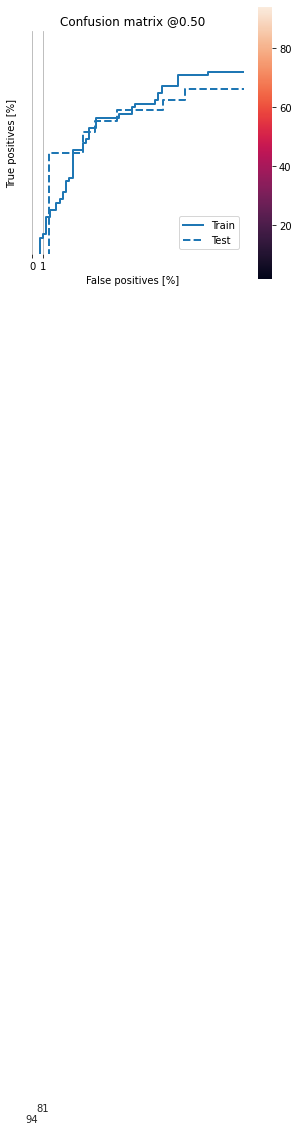

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 427s 33s/step - loss: 0.8240 - tp: 246.3571 - fp: 192.5000 - tn: 94.0000 - fn: 36.0000 - accuracy: 0.6198 - precision: 0.5878 - recall: 0.8628 - auc: 0.6961 - val_loss: 0.7368 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.7250
Epoch 2/10000
13/13 [==============================] - 429s 33s/step - loss: 0.8171 - tp: 165.1429 - fp: 191.4286 - tn: 0.5000 - fn: 12.7857 - accuracy: 0.4384 - precision: 0.4539 - recall: 0.9245 - auc: 0.5169 - val_loss: 0.7279 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.7025
Epoch 3/10000
13/13 [==============================] - 427s 33s/step - loss: 0.8220 - tp: 159.5714 - fp: 193.7857 - tn: 0.0000e+00 - fn: 16.5000 - accuracy: 0.4211 - precision: 0.4402 - recall: 0.9076 - auc: 0.4

Epoch 22/10000
13/13 [==============================] - 426s 33s/step - loss: 0.6570 - tp: 168.2143 - fp: 184.8571 - tn: 2.7143 - fn: 14.0714 - accuracy: 0.4657 - precision: 0.4821 - recall: 0.9155 - auc: 0.6262 - val_loss: 0.6171 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8379
Epoch 23/10000
13/13 [==============================] - 425s 33s/step - loss: 0.6509 - tp: 171.5000 - fp: 187.6429 - tn: 0.7857 - fn: 9.9286 - accuracy: 0.4701 - precision: 0.4823 - recall: 0.9459 - auc: 0.6379 - val_loss: 0.6157 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8068
Epoch 24/10000
13/13 [==============================] - 426s 33s/step - loss: 0.6555 - tp: 163.2143 - fp: 191.7143 - tn: 2.0000 - fn: 12.9286 - accuracy: 0.4477 - precision: 0.4635 - recall: 0.9191 - auc: 0.6282

13/13 [==============================] - 427s 33s/step - loss: 0.5951 - tp: 68.5000 - fp: 6.7857 - tn: 184.8571 - fn: 109.7143 - accuracy: 0.6900 - precision: 0.9152 - recall: 0.3978 - auc: 0.7050 - val_loss: 0.5661 - val_tp: 59.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 27.0000 - val_accuracy: 0.7799 - val_precision: 0.8806 - val_recall: 0.6860 - val_auc: 0.8046
Epoch 65/10000
13/13 [==============================] - 428s 33s/step - loss: 0.6155 - tp: 62.4286 - fp: 8.1429 - tn: 183.4286 - fn: 115.8571 - accuracy: 0.6607 - precision: 0.8778 - recall: 0.3415 - auc: 0.6957 - val_loss: 0.5628 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 25.0000 - val_accuracy: 0.7925 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.8163
Epoch 66/10000
13/13 [==============================] - 425s 33s/step - loss: 0.5856 - tp: 72.4286 - fp: 7.5000 - tn: 185.1429 - fn: 104.7857 - accuracy: 0.7073 - precision: 0.9173 - recall: 0.4224 - auc: 0.6948 - val_loss: 0.5629 - val_tp

13/13 [==============================] - 433s 33s/step - loss: 0.5353 - tp: 80.9286 - fp: 8.6429 - tn: 179.2143 - fn: 101.0714 - accuracy: 0.7007 - precision: 0.8946 - recall: 0.4567 - auc: 0.8115 - val_loss: 0.5075 - val_tp: 64.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 22.0000 - val_accuracy: 0.8050 - val_precision: 0.8767 - val_recall: 0.7442 - val_auc: 0.8930
Epoch 107/10000
13/13 [==============================] - 433s 33s/step - loss: 0.5438 - tp: 69.2143 - fp: 5.7857 - tn: 183.2143 - fn: 111.6429 - accuracy: 0.6844 - precision: 0.9274 - recall: 0.3814 - auc: 0.7757 - val_loss: 0.4997 - val_tp: 66.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 20.0000 - val_accuracy: 0.8239 - val_precision: 0.8919 - val_recall: 0.7674 - val_auc: 0.8954
Epoch 108/10000
13/13 [==============================] - 431s 33s/step - loss: 0.5343 - tp: 80.7143 - fp: 11.5714 - tn: 178.0000 - fn: 99.5714 - accuracy: 0.7032 - precision: 0.8580 - recall: 0.4668 - auc: 0.8072 - val_loss: 0.4981 - val_

13/13 [==============================] - 432s 33s/step - loss: 0.5155 - tp: 79.6429 - fp: 14.9286 - tn: 176.7143 - fn: 98.5714 - accuracy: 0.6821 - precision: 0.8216 - recall: 0.4357 - auc: 0.7894 - val_loss: 0.4534 - val_tp: 72.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 14.0000 - val_accuracy: 0.8553 - val_precision: 0.8889 - val_recall: 0.8372 - val_auc: 0.9259
Epoch 149/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4815 - tp: 94.2143 - fp: 14.6429 - tn: 172.0000 - fn: 89.0000 - accuracy: 0.7201 - precision: 0.8790 - recall: 0.5148 - auc: 0.8415 - val_loss: 0.4513 - val_tp: 74.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 12.0000 - val_accuracy: 0.8805 - val_precision: 0.9136 - val_recall: 0.8605 - val_auc: 0.9251
Epoch 150/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4871 - tp: 80.0714 - fp: 16.9286 - tn: 179.6429 - fn: 93.2143 - accuracy: 0.7088 - precision: 0.8198 - recall: 0.4793 - auc: 0.8190 - val_loss: 0.4541 - val_

13/13 [==============================] - 432s 33s/step - loss: 0.5282 - tp: 77.3571 - fp: 23.7857 - tn: 173.3571 - fn: 95.3571 - accuracy: 0.6830 - precision: 0.7599 - recall: 0.4632 - auc: 0.7635 - val_loss: 0.4289 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9442
Epoch 191/10000
13/13 [==============================] - 433s 33s/step - loss: 0.5077 - tp: 83.0714 - fp: 23.2857 - tn: 169.7143 - fn: 93.7857 - accuracy: 0.6795 - precision: 0.7701 - recall: 0.4653 - auc: 0.7822 - val_loss: 0.4313 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9441
Epoch 192/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4819 - tp: 96.3571 - fp: 16.7857 - tn: 177.5714 - fn: 79.1429 - accuracy: 0.7452 - precision: 0.8591 - recall: 0.5472 - auc: 0.8130 - val_loss: 0.4304 - val_

13/13 [==============================] - 433s 33s/step - loss: 0.5257 - tp: 82.5714 - fp: 38.3571 - tn: 158.8571 - fn: 90.0714 - accuracy: 0.6521 - precision: 0.6823 - recall: 0.4729 - auc: 0.7566 - val_loss: 0.4192 - val_tp: 75.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 11.0000 - val_accuracy: 0.8868 - val_precision: 0.9146 - val_recall: 0.8721 - val_auc: 0.9449
Epoch 233/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4714 - tp: 106.2143 - fp: 33.0000 - tn: 158.6429 - fn: 72.0000 - accuracy: 0.7185 - precision: 0.7628 - recall: 0.5908 - auc: 0.8284 - val_loss: 0.4172 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9450
Epoch 234/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4854 - tp: 104.0714 - fp: 38.8571 - tn: 154.6429 - fn: 72.2857 - accuracy: 0.6985 - precision: 0.7093 - recall: 0.5937 - auc: 0.8108 - val_loss: 0.4174 - val

13/13 [==============================] - 431s 33s/step - loss: 0.4722 - tp: 92.0000 - fp: 35.6429 - tn: 163.0714 - fn: 79.1429 - accuracy: 0.7009 - precision: 0.6997 - recall: 0.5656 - auc: 0.8152 - val_loss: 0.4098 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9450
Epoch 275/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4680 - tp: 95.7143 - fp: 31.2143 - tn: 159.8571 - fn: 83.0714 - accuracy: 0.6945 - precision: 0.7708 - recall: 0.5299 - auc: 0.8160 - val_loss: 0.4073 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9465
Epoch 276/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4727 - tp: 100.2143 - fp: 30.0000 - tn: 159.2143 - fn: 80.4286 - accuracy: 0.6854 - precision: 0.7528 - recall: 0.5357 - auc: 0.8176 - val_loss: 0.4041 - val

13/13 [==============================] - 433s 33s/step - loss: 0.4707 - tp: 97.0000 - fp: 36.1429 - tn: 154.2857 - fn: 82.4286 - accuracy: 0.6767 - precision: 0.7314 - recall: 0.5448 - auc: 0.8067 - val_loss: 0.4043 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9482
Epoch 317/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4351 - tp: 105.5714 - fp: 28.2857 - tn: 165.5000 - fn: 70.5000 - accuracy: 0.7439 - precision: 0.8041 - recall: 0.6015 - auc: 0.8548 - val_loss: 0.4014 - val_tp: 77.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 9.0000 - val_accuracy: 0.9245 - val_precision: 0.9625 - val_recall: 0.8953 - val_auc: 0.9511
Epoch 318/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4734 - tp: 103.0000 - fp: 33.7857 - tn: 160.9286 - fn: 72.1429 - accuracy: 0.7009 - precision: 0.7439 - recall: 0.5680 - auc: 0.8213 - val_loss: 0.3990 - val_

13/13 [==============================] - 431s 33s/step - loss: 0.4764 - tp: 91.5714 - fp: 33.0000 - tn: 158.0714 - fn: 87.2143 - accuracy: 0.6726 - precision: 0.7402 - recall: 0.4977 - auc: 0.7966 - val_loss: 0.3930 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9469
Epoch 359/10000
13/13 [==============================] - 431s 33s/step - loss: 0.4926 - tp: 107.6429 - fp: 40.3571 - tn: 147.1429 - fn: 74.7143 - accuracy: 0.6891 - precision: 0.7298 - recall: 0.5911 - auc: 0.7985 - val_loss: 0.3981 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9469
Epoch 360/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4868 - tp: 100.3571 - fp: 33.2143 - tn: 155.7857 - fn: 80.5000 - accuracy: 0.6947 - precision: 0.7598 - recall: 0.5518 - auc: 0.8226 - val_loss: 0.3969 - va

13/13 [==============================] - 432s 33s/step - loss: 0.4984 - tp: 99.0714 - fp: 39.9286 - tn: 150.2857 - fn: 80.5714 - accuracy: 0.6609 - precision: 0.7131 - recall: 0.5366 - auc: 0.7880 - val_loss: 0.3957 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9454
Epoch 401/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4456 - tp: 112.0714 - fp: 37.7143 - tn: 155.8571 - fn: 64.2143 - accuracy: 0.7291 - precision: 0.7537 - recall: 0.6428 - auc: 0.8328 - val_loss: 0.3924 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9522
Epoch 402/10000
13/13 [==============================] - 432s 33s/step - loss: 0.5142 - tp: 100.0714 - fp: 42.7143 - tn: 148.8571 - fn: 78.2143 - accuracy: 0.6507 - precision: 0.6775 - recall: 0.5346 - auc: 0.7610 - val_loss: 0.3901 - va

13/13 [==============================] - 431s 33s/step - loss: 0.4936 - tp: 101.4286 - fp: 38.7143 - tn: 150.3571 - fn: 79.3571 - accuracy: 0.6804 - precision: 0.7245 - recall: 0.5506 - auc: 0.7780 - val_loss: 0.3788 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9533
Epoch 443/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4711 - tp: 110.2857 - fp: 45.7143 - tn: 145.9286 - fn: 67.9286 - accuracy: 0.6936 - precision: 0.7098 - recall: 0.6293 - auc: 0.8132 - val_loss: 0.3842 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9549
Epoch 444/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4734 - tp: 98.5000 - fp: 34.7857 - tn: 160.7857 - fn: 75.7857 - accuracy: 0.7070 - precision: 0.7405 - recall: 0.5744 - auc: 0.8163 - val_loss: 0.3863 - va

13/13 [==============================] - 413s 32s/step - loss: 0.4980 - tp: 110.4286 - fp: 36.3571 - tn: 143.2143 - fn: 79.8571 - accuracy: 0.6875 - precision: 0.7652 - recall: 0.5834 - auc: 0.7838 - val_loss: 0.3934 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9478
Epoch 485/10000
13/13 [==============================] - 412s 32s/step - loss: 0.4970 - tp: 100.6429 - fp: 31.7143 - tn: 158.7143 - fn: 78.7857 - accuracy: 0.6927 - precision: 0.7435 - recall: 0.5476 - auc: 0.8009 - val_loss: 0.3919 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9479
Epoch 486/10000
13/13 [==============================] - 412s 32s/step - loss: 0.4796 - tp: 91.7857 - fp: 31.5000 - tn: 164.1429 - fn: 82.4286 - accuracy: 0.6852 - precision: 0.7449 - recall: 0.5134 - auc: 0.7891 - val_loss: 0.3903 - va

13/13 [==============================] - 413s 32s/step - loss: 0.4669 - tp: 112.1429 - fp: 36.7143 - tn: 155.5000 - fn: 65.5000 - accuracy: 0.7186 - precision: 0.7634 - recall: 0.6106 - auc: 0.8202 - val_loss: 0.3822 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9479
Epoch 527/10000
13/13 [==============================] - 412s 32s/step - loss: 0.4620 - tp: 117.1429 - fp: 40.8571 - tn: 151.0000 - fn: 60.8571 - accuracy: 0.7356 - precision: 0.7554 - recall: 0.6649 - auc: 0.8351 - val_loss: 0.3799 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9483
Epoch 528/10000
13/13 [==============================] - 414s 32s/step - loss: 0.4297 - tp: 113.0000 - fp: 40.2143 - tn: 151.3571 - fn: 65.2857 - accuracy: 0.7139 - precision: 0.7399 - recall: 0.6378 - auc: 0.8424 - val_loss: 0.3782 - va

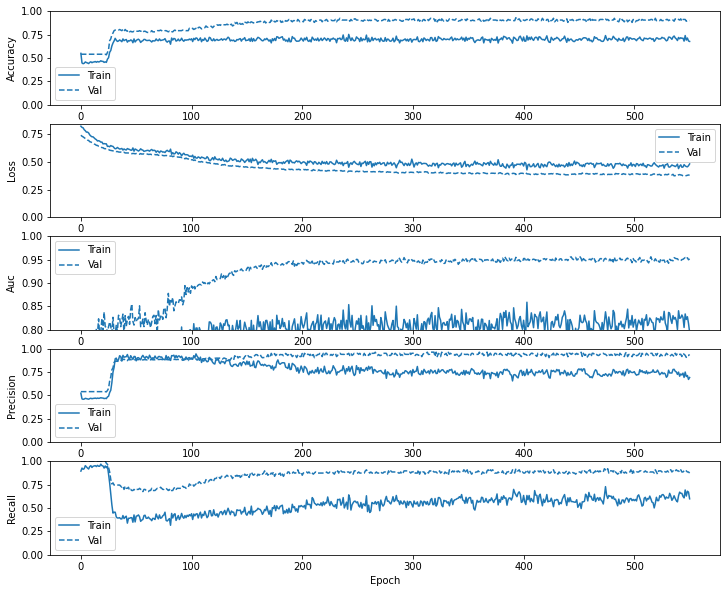

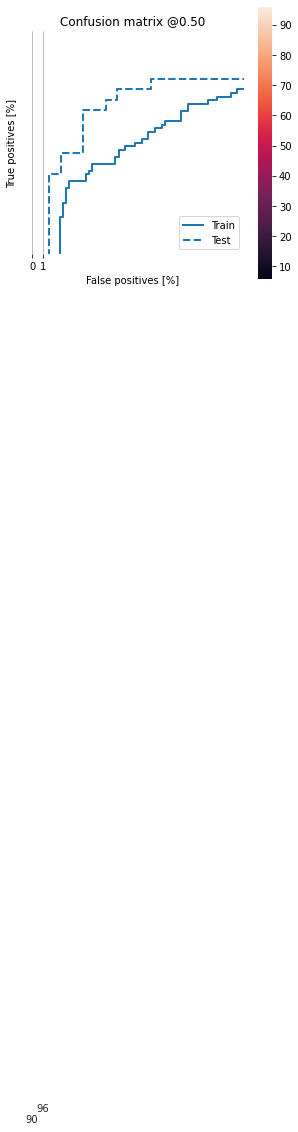

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 865s 66s/step - loss: 0.6762 - tp: 130.8571 - fp: 15.2857 - tn: 271.2143 - fn: 151.5000 - accuracy: 0.7257 - precision: 0.8974 - recall: 0.5038 - auc: 0.8051 - val_loss: 0.6776 - val_tp: 35.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 51.0000 - val_accuracy: 0.6415 - val_precision: 0.8537 - val_recall: 0.4070 - val_auc: 0.6547
Epoch 2/10000
13/13 [==============================] - 863s 66s/step - loss: 0.6702 - tp: 40.6429 - fp: 10.7857 - tn: 181.1429 - fn: 137.2857 - accuracy: 0.6126 - precision: 0.8130 - recall: 0.2361 - auc: 0.6140 - val_loss: 0.6704 - val_tp: 40.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 46.0000 - val_accuracy: 0.6792 - val_precision: 0.8889 - val_recall: 0.4651 - val_auc: 0.7349
Epoch 3/10000
13/13 [==============================] - 864s 66s/step - loss: 0.6604 - tp: 45.0000 - fp: 6.2143 - tn: 187.5714 - fn: 131.0714 - accuracy: 0.6428 - precision: 0.8995 - recall: 0.2610 - auc: 0.6612 - val_loss: 

13/13 [==============================] - 867s 67s/step - loss: 0.6061 - tp: 69.8571 - fp: 6.0000 - tn: 185.7857 - fn: 108.2143 - accuracy: 0.6913 - precision: 0.9277 - recall: 0.3866 - auc: 0.7214 - val_loss: 0.5894 - val_tp: 48.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 38.0000 - val_accuracy: 0.7358 - val_precision: 0.9231 - val_recall: 0.5581 - val_auc: 0.8620
Epoch 44/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5996 - tp: 71.7857 - fp: 7.8571 - tn: 185.4286 - fn: 104.7857 - accuracy: 0.7028 - precision: 0.8841 - recall: 0.4218 - auc: 0.7363 - val_loss: 0.5886 - val_tp: 47.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 39.0000 - val_accuracy: 0.7233 - val_precision: 0.9038 - val_recall: 0.5465 - val_auc: 0.8496
Epoch 45/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5933 - tp: 77.8571 - fp: 6.3571 - tn: 184.9286 - fn: 100.7143 - accuracy: 0.7017 - precision: 0.9151 - recall: 0.4248 - auc: 0.7510 - val_loss: 0.5899 - val_tp

13/13 [==============================] - 867s 67s/step - loss: 0.5803 - tp: 77.5714 - fp: 7.4286 - tn: 186.2143 - fn: 98.6429 - accuracy: 0.7100 - precision: 0.9137 - recall: 0.4226 - auc: 0.7255 - val_loss: 0.5607 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9020
Epoch 86/10000
13/13 [==============================] - 868s 67s/step - loss: 0.5668 - tp: 88.6429 - fp: 7.7143 - tn: 178.2143 - fn: 95.2857 - accuracy: 0.7150 - precision: 0.9148 - recall: 0.4790 - auc: 0.7281 - val_loss: 0.5595 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8866
Epoch 87/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5652 - tp: 79.2857 - fp: 9.4286 - tn: 180.2143 - fn: 100.9286 - accuracy: 0.7129 - precision: 0.8939 - recall: 0.4691 - auc: 0.7352 - val_loss: 0.5621 - val_tp: 

13/13 [==============================] - 869s 67s/step - loss: 0.5592 - tp: 88.0000 - fp: 9.0714 - tn: 177.6429 - fn: 95.1429 - accuracy: 0.7217 - precision: 0.9130 - recall: 0.4973 - auc: 0.7206 - val_loss: 0.5482 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9112
Epoch 128/10000
13/13 [==============================] - 868s 67s/step - loss: 0.5625 - tp: 84.2857 - fp: 9.5714 - tn: 180.7143 - fn: 95.2857 - accuracy: 0.7125 - precision: 0.9017 - recall: 0.4672 - auc: 0.7094 - val_loss: 0.5439 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9049
Epoch 129/10000
13/13 [==============================] - 868s 67s/step - loss: 0.5741 - tp: 83.2143 - fp: 8.2857 - tn: 176.2143 - fn: 102.1429 - accuracy: 0.6995 - precision: 0.9306 - recall: 0.4504 - auc: 0.7117 - val_loss: 0.5429 - val_tp

13/13 [==============================] - 870s 67s/step - loss: 0.5498 - tp: 88.9286 - fp: 6.2143 - tn: 184.7857 - fn: 89.9286 - accuracy: 0.7344 - precision: 0.9481 - recall: 0.4859 - auc: 0.7334 - val_loss: 0.5244 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9166
Epoch 170/10000
13/13 [==============================] - 871s 67s/step - loss: 0.5415 - tp: 87.9286 - fp: 6.5714 - tn: 187.7857 - fn: 87.5714 - accuracy: 0.7440 - precision: 0.9184 - recall: 0.4952 - auc: 0.7617 - val_loss: 0.5236 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9055
Epoch 171/10000
13/13 [==============================] - 869s 67s/step - loss: 0.5323 - tp: 88.0714 - fp: 6.1429 - tn: 188.3571 - fn: 87.2857 - accuracy: 0.7519 - precision: 0.9348 - recall: 0.5107 - auc: 0.7561 - val_loss: 0.5248 - val_tp:

13/13 [==============================] - 867s 67s/step - loss: 0.5244 - tp: 92.0714 - fp: 2.2143 - tn: 188.9286 - fn: 86.6429 - accuracy: 0.7541 - precision: 0.9780 - recall: 0.5021 - auc: 0.7956 - val_loss: 0.5316 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9066
Epoch 212/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5520 - tp: 83.6429 - fp: 11.0000 - tn: 182.4286 - fn: 92.7857 - accuracy: 0.7154 - precision: 0.8819 - recall: 0.4707 - auc: 0.7553 - val_loss: 0.5285 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9147
Epoch 213/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5401 - tp: 94.0714 - fp: 10.5714 - tn: 180.7143 - fn: 84.5000 - accuracy: 0.7362 - precision: 0.8832 - recall: 0.5143 - auc: 0.7486 - val_loss: 0.5276 - val_t

13/13 [==============================] - 867s 67s/step - loss: 0.5094 - tp: 97.9286 - fp: 6.5000 - tn: 187.2857 - fn: 78.1429 - accuracy: 0.7722 - precision: 0.9286 - recall: 0.5581 - auc: 0.8028 - val_loss: 0.5377 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9111
Epoch 254/10000
13/13 [==============================] - 869s 67s/step - loss: 0.4934 - tp: 105.7857 - fp: 6.1429 - tn: 183.7857 - fn: 74.1429 - accuracy: 0.7848 - precision: 0.9390 - recall: 0.5873 - auc: 0.8024 - val_loss: 0.5348 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9231
Epoch 255/10000
13/13 [==============================] - 867s 67s/step - loss: 0.4985 - tp: 107.5714 - fp: 5.5000 - tn: 184.0714 - fn: 72.7143 - accuracy: 0.7969 - precision: 0.9627 - recall: 0.6049 - auc: 0.8005 - val_loss: 0.5357 - val_t

13/13 [==============================] - 867s 67s/step - loss: 0.4933 - tp: 108.5000 - fp: 12.1429 - tn: 177.0000 - fn: 72.2143 - accuracy: 0.7712 - precision: 0.8897 - recall: 0.6033 - auc: 0.8093 - val_loss: 0.5325 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9271
Epoch 296/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5096 - tp: 108.5714 - fp: 11.8571 - tn: 179.4286 - fn: 70.0000 - accuracy: 0.7717 - precision: 0.8894 - recall: 0.6059 - auc: 0.8058 - val_loss: 0.5322 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9207
Epoch 297/10000
13/13 [==============================] - 866s 67s/step - loss: 0.4945 - tp: 104.7857 - fp: 5.2857 - tn: 187.2857 - fn: 72.5000 - accuracy: 0.7883 - precision: 0.9567 - recall: 0.5880 - auc: 0.7799 - val_loss: 0.5309 - va

13/13 [==============================] - 868s 67s/step - loss: 0.5150 - tp: 95.7857 - fp: 7.9286 - tn: 192.0000 - fn: 74.1429 - accuracy: 0.7754 - precision: 0.9151 - recall: 0.5548 - auc: 0.7391 - val_loss: 0.5258 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9367
Epoch 338/10000
13/13 [==============================] - 867s 67s/step - loss: 0.5179 - tp: 95.7857 - fp: 8.3571 - tn: 188.0714 - fn: 77.6429 - accuracy: 0.7710 - precision: 0.9188 - recall: 0.5503 - auc: 0.7610 - val_loss: 0.5225 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9310
Epoch 339/10000
13/13 [==============================] - 866s 67s/step - loss: 0.5030 - tp: 109.9286 - fp: 7.2857 - tn: 181.3571 - fn: 71.2857 - accuracy: 0.7786 - precision: 0.9448 - recall: 0.5963 - auc: 0.7743 - val_loss: 0.5250 - val_tp

13/13 [==============================] - 866s 67s/step - loss: 0.4892 - tp: 107.3571 - fp: 4.3571 - tn: 187.7857 - fn: 70.3571 - accuracy: 0.7964 - precision: 0.9626 - recall: 0.6048 - auc: 0.7865 - val_loss: 0.5122 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9465
Epoch 380/10000
13/13 [==============================] - 868s 67s/step - loss: 0.5099 - tp: 97.1429 - fp: 9.0714 - tn: 185.5000 - fn: 78.1429 - accuracy: 0.7602 - precision: 0.8971 - recall: 0.5545 - auc: 0.7883 - val_loss: 0.5156 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9402
Epoch 381/10000
13/13 [==============================] - 867s 67s/step - loss: 0.4646 - tp: 111.2143 - fp: 5.2857 - tn: 188.8571 - fn: 64.5000 - accuracy: 0.8110 - precision: 0.9527 - recall: 0.6369 - auc: 0.8052 - val_loss: 0.5167 - val_t

13/13 [==============================] - 867s 67s/step - loss: 0.4738 - tp: 107.7857 - fp: 5.0000 - tn: 189.8571 - fn: 67.2143 - accuracy: 0.8119 - precision: 0.9591 - recall: 0.6227 - auc: 0.7796 - val_loss: 0.5115 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9302
Epoch 422/10000
13/13 [==============================] - 867s 67s/step - loss: 0.4901 - tp: 109.7143 - fp: 8.5714 - tn: 183.4286 - fn: 68.1429 - accuracy: 0.7855 - precision: 0.9062 - recall: 0.6079 - auc: 0.7930 - val_loss: 0.5089 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9414
Epoch 423/10000
13/13 [==============================] - 865s 67s/step - loss: 0.5376 - tp: 100.7143 - fp: 8.2143 - tn: 175.4286 - fn: 85.5000 - accuracy: 0.7325 - precision: 0.9182 - recall: 0.5334 - auc: 0.7479 - val_loss: 0.5079 - val_

13/13 [==============================] - 866s 67s/step - loss: 0.4893 - tp: 97.8571 - fp: 4.0000 - tn: 188.2857 - fn: 79.7143 - accuracy: 0.7800 - precision: 0.9659 - recall: 0.5622 - auc: 0.7759 - val_loss: 0.4978 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9425
Epoch 464/10000
13/13 [==============================] - 865s 67s/step - loss: 0.4878 - tp: 107.0000 - fp: 6.5000 - tn: 182.0714 - fn: 74.2857 - accuracy: 0.7863 - precision: 0.9494 - recall: 0.5962 - auc: 0.7692 - val_loss: 0.4933 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9440
Epoch 465/10000
13/13 [==============================] - 867s 67s/step - loss: 0.4453 - tp: 115.3571 - fp: 6.5000 - tn: 187.0714 - fn: 60.9286 - accuracy: 0.8220 - precision: 0.9444 - recall: 0.6589 - auc: 0.8228 - val_loss: 0.4949 - val_t

13/13 [==============================] - 867s 67s/step - loss: 0.4968 - tp: 109.3571 - fp: 5.3571 - tn: 178.2857 - fn: 76.8571 - accuracy: 0.7631 - precision: 0.9494 - recall: 0.5775 - auc: 0.7932 - val_loss: 0.4971 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9438
Epoch 506/10000
13/13 [==============================] - 866s 67s/step - loss: 0.4775 - tp: 110.9286 - fp: 5.7143 - tn: 184.5714 - fn: 68.6429 - accuracy: 0.7965 - precision: 0.9473 - recall: 0.6026 - auc: 0.7981 - val_loss: 0.4995 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9371
Epoch 507/10000
13/13 [==============================] - 868s 67s/step - loss: 0.4790 - tp: 107.2857 - fp: 8.2143 - tn: 185.2857 - fn: 69.0714 - accuracy: 0.7892 - precision: 0.9252 - recall: 0.5970 - auc: 0.8008 - val_loss: 0.4914 - val_

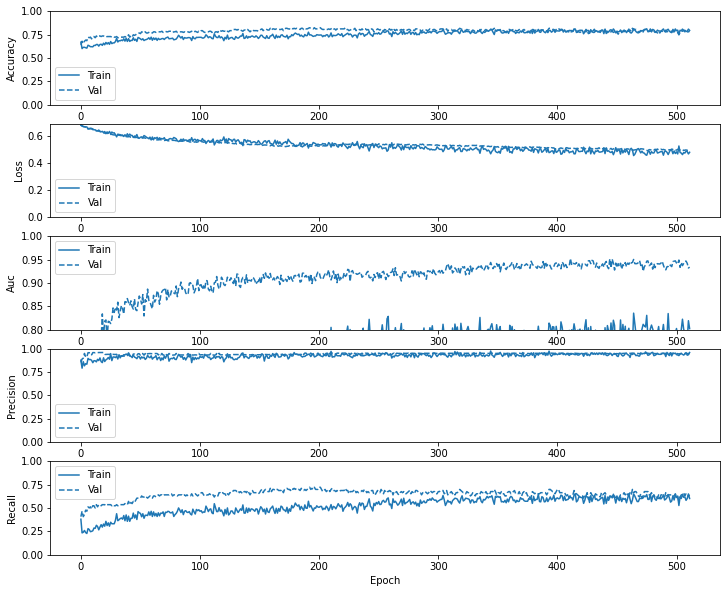

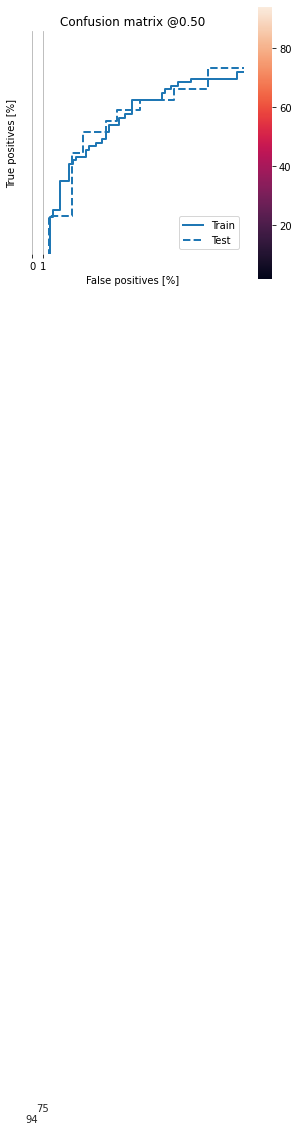

In [21]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 535s 41s/step - loss: 0.6978 - tp: 120.5714 - fp: 32.5714 - tn: 253.9286 - fn: 161.7857 - accuracy: 0.6752 - precision: 0.7988 - recall: 0.4567 - auc: 0.7375 - val_loss: 0.7188 - val_tp: 15.0000 - val_fp: 15.0000 - val_tn: 58.0000 - val_fn: 71.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.1744 - val_auc: 0.3350
Epoch 2/10000
13/13 [==============================] - 535s 41s/step - loss: 0.7030 - tp: 42.2143 - fp: 39.7857 - tn: 152.1429 - fn: 135.7143 - accuracy: 0.5353 - precision: 0.5189 - recall: 0.2479 - auc: 0.4636 - val_loss: 0.7213 - val_tp: 10.0000 - val_fp: 14.0000 - val_tn: 59.0000 - val_fn: 76.0000 - val_accuracy: 0.4340 - val_precision: 0.4167 - val_recall: 0.1163 - val_auc: 0.3101
Epoch 3/10000
13/13 [==============================] - 536s 41s/step - loss: 0.7083 - tp: 43.3571 - fp: 32.0000 - tn: 161.7857 - fn: 132.7143 - accuracy: 0.5544 - precision: 0.5480 - recall: 0.2478 - auc: 0.4859 - val_los

13/13 [==============================] - 538s 41s/step - loss: 0.6807 - tp: 50.6429 - fp: 13.8571 - tn: 177.9286 - fn: 127.4286 - accuracy: 0.6215 - precision: 0.8151 - recall: 0.2760 - auc: 0.5715 - val_loss: 0.7659 - val_tp: 12.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 74.0000 - val_accuracy: 0.4654 - val_precision: 0.5217 - val_recall: 0.1395 - val_auc: 0.2910
Epoch 44/10000
13/13 [==============================] - 537s 41s/step - loss: 0.6858 - tp: 40.1429 - fp: 9.6429 - tn: 183.6429 - fn: 136.4286 - accuracy: 0.6057 - precision: 0.7674 - recall: 0.2230 - auc: 0.5379 - val_loss: 0.7624 - val_tp: 13.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 73.0000 - val_accuracy: 0.4906 - val_precision: 0.6190 - val_recall: 0.1512 - val_auc: 0.3270
Epoch 45/10000
13/13 [==============================] - 538s 41s/step - loss: 0.6769 - tp: 51.9286 - fp: 10.9286 - tn: 180.3571 - fn: 126.6429 - accuracy: 0.6229 - precision: 0.8162 - recall: 0.2881 - auc: 0.5994 - val_loss: 0.7647 - val

13/13 [==============================] - 538s 41s/step - loss: 0.6707 - tp: 49.7857 - fp: 11.0000 - tn: 182.6429 - fn: 126.4286 - accuracy: 0.6273 - precision: 0.8107 - recall: 0.2691 - auc: 0.5506 - val_loss: 0.7803 - val_tp: 18.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 68.0000 - val_accuracy: 0.5283 - val_precision: 0.7200 - val_recall: 0.2093 - val_auc: 0.3668
Epoch 86/10000
13/13 [==============================] - 537s 41s/step - loss: 0.6665 - tp: 50.9286 - fp: 8.5000 - tn: 177.4286 - fn: 133.0000 - accuracy: 0.6166 - precision: 0.8626 - recall: 0.2843 - auc: 0.6186 - val_loss: 0.7877 - val_tp: 16.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 70.0000 - val_accuracy: 0.5157 - val_precision: 0.6957 - val_recall: 0.1860 - val_auc: 0.2987
Epoch 87/10000
13/13 [==============================] - 537s 41s/step - loss: 0.6673 - tp: 51.2143 - fp: 7.9286 - tn: 181.7143 - fn: 129.0000 - accuracy: 0.6330 - precision: 0.8550 - recall: 0.3018 - auc: 0.5865 - val_loss: 0.7835 - val_t

13/13 [==============================] - 537s 41s/step - loss: 0.6336 - tp: 61.8571 - fp: 6.3571 - tn: 180.3571 - fn: 121.2857 - accuracy: 0.6633 - precision: 0.9218 - recall: 0.3633 - auc: 0.6609 - val_loss: 0.8462 - val_tp: 18.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 68.0000 - val_accuracy: 0.5409 - val_precision: 0.7826 - val_recall: 0.2093 - val_auc: 0.3353
Epoch 128/10000
13/13 [==============================] - 535s 41s/step - loss: 0.6425 - tp: 59.2857 - fp: 9.0000 - tn: 181.2857 - fn: 120.2857 - accuracy: 0.6518 - precision: 0.8760 - recall: 0.3404 - auc: 0.6463 - val_loss: 0.8468 - val_tp: 18.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 68.0000 - val_accuracy: 0.5472 - val_precision: 0.8182 - val_recall: 0.2093 - val_auc: 0.3433
Epoch 129/10000
13/13 [==============================] - 538s 41s/step - loss: 0.6388 - tp: 63.2143 - fp: 9.5000 - tn: 175.0000 - fn: 122.1429 - accuracy: 0.6377 - precision: 0.8792 - recall: 0.3443 - auc: 0.6711 - val_loss: 0.8496 - val_

13/13 [==============================] - 535s 41s/step - loss: 0.6296 - tp: 59.9286 - fp: 11.1429 - tn: 179.8571 - fn: 118.9286 - accuracy: 0.6457 - precision: 0.8486 - recall: 0.3382 - auc: 0.6604 - val_loss: 0.9175 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.3451
Epoch 170/10000
13/13 [==============================] - 537s 41s/step - loss: 0.6214 - tp: 64.7857 - fp: 12.0000 - tn: 182.3571 - fn: 110.7143 - accuracy: 0.6706 - precision: 0.8392 - recall: 0.3647 - auc: 0.6516 - val_loss: 0.9145 - val_tp: 19.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 67.0000 - val_accuracy: 0.5535 - val_precision: 0.8261 - val_recall: 0.2209 - val_auc: 0.3229
Epoch 171/10000
13/13 [==============================] - 536s 41s/step - loss: 0.6082 - tp: 70.7857 - fp: 7.9286 - tn: 186.5714 - fn: 104.5714 - accuracy: 0.7051 - precision: 0.9188 - recall: 0.4127 - auc: 0.6958 - val_loss: 0.9082 - va

13/13 [==============================] - 536s 41s/step - loss: 0.6191 - tp: 67.5714 - fp: 4.5000 - tn: 186.6429 - fn: 111.1429 - accuracy: 0.6793 - precision: 0.9466 - recall: 0.3570 - auc: 0.6610 - val_loss: 0.9253 - val_tp: 19.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 67.0000 - val_accuracy: 0.5597 - val_precision: 0.8636 - val_recall: 0.2209 - val_auc: 0.3381
Epoch 212/10000
13/13 [==============================] - 539s 41s/step - loss: 0.6030 - tp: 65.7857 - fp: 11.2857 - tn: 182.1429 - fn: 110.6429 - accuracy: 0.6706 - precision: 0.8487 - recall: 0.3823 - auc: 0.7055 - val_loss: 0.9296 - val_tp: 18.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 68.0000 - val_accuracy: 0.5472 - val_precision: 0.8182 - val_recall: 0.2093 - val_auc: 0.3471
Epoch 213/10000
13/13 [==============================] - 537s 41s/step - loss: 0.6103 - tp: 70.5714 - fp: 7.7857 - tn: 183.5000 - fn: 108.0000 - accuracy: 0.6802 - precision: 0.8761 - recall: 0.3827 - auc: 0.6327 - val_loss: 0.9324 - val

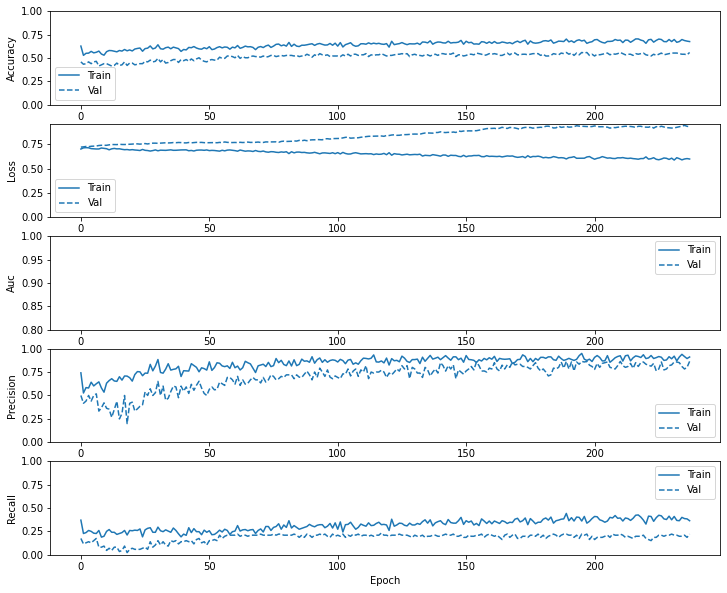

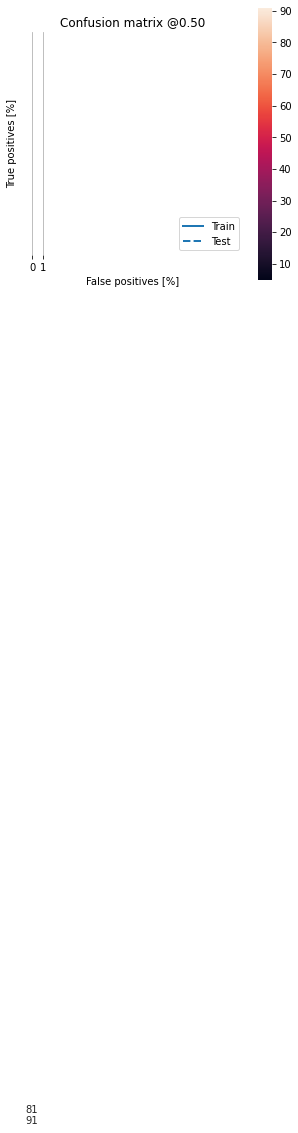

In [22]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 513s 40s/step - loss: 0.7264 - tp: 48.1429 - fp: 35.3571 - tn: 251.1429 - fn: 234.2143 - accuracy: 0.5282 - precision: 0.5911 - recall: 0.1705 - auc: 0.4092 - val_loss: 0.7571 - val_tp: 3.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 83.0000 - val_accuracy: 0.4088 - val_precision: 0.2143 - val_recall: 0.0349 - val_auc: 0.2365
Epoch 2/10000
13/13 [==============================] - 511s 39s/step - loss: 0.7230 - tp: 34.2143 - fp: 24.5000 - tn: 167.4286 - fn: 143.7143 - accuracy: 0.5481 - precision: 0.5696 - recall: 0.1909 - auc: 0.4290 - val_loss: 0.7557 - val_tp: 4.0000 - val_fp: 12.0000 - val_tn: 61.0000 - val_fn: 82.0000 - val_accuracy: 0.4088 - val_precision: 0.2500 - val_recall: 0.0465 - val_auc: 0.2119
Epoch 3/10000
13/13 [==============================] - 514s 40s/step - loss: 0.7095 - tp: 37.6429 - fp: 25.0000 - tn: 168.7857 - fn: 138.4286 - accuracy: 0.5701 - precision: 0.6034 - recall: 0.2132 - auc: 0.4917 - val_loss: 

13/13 [==============================] - 516s 40s/step - loss: 0.6833 - tp: 44.0000 - fp: 37.4286 - tn: 154.3571 - fn: 134.0714 - accuracy: 0.5484 - precision: 0.5647 - recall: 0.2553 - auc: 0.5584 - val_loss: 0.6846 - val_tp: 17.0000 - val_fp: 16.0000 - val_tn: 57.0000 - val_fn: 69.0000 - val_accuracy: 0.4654 - val_precision: 0.5152 - val_recall: 0.1977 - val_auc: 0.5957
Epoch 44/10000
13/13 [==============================] - 514s 40s/step - loss: 0.6852 - tp: 37.5714 - fp: 44.2143 - tn: 149.0714 - fn: 139.0000 - accuracy: 0.5232 - precision: 0.4765 - recall: 0.2310 - auc: 0.5468 - val_loss: 0.6872 - val_tp: 19.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 67.0000 - val_accuracy: 0.4654 - val_precision: 0.5135 - val_recall: 0.2209 - val_auc: 0.5539
Epoch 45/10000
13/13 [==============================] - 513s 39s/step - loss: 0.6820 - tp: 37.1429 - fp: 37.5714 - tn: 153.7143 - fn: 141.4286 - accuracy: 0.5211 - precision: 0.5203 - recall: 0.2067 - auc: 0.5714 - val_loss: 0.6867 - v

13/13 [==============================] - 515s 40s/step - loss: 0.6302 - tp: 146.9286 - fp: 102.9286 - tn: 90.7143 - fn: 29.2857 - accuracy: 0.6347 - precision: 0.5772 - recall: 0.8363 - auc: 0.6670 - val_loss: 0.5981 - val_tp: 58.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 28.0000 - val_accuracy: 0.8113 - val_precision: 0.9667 - val_recall: 0.6744 - val_auc: 0.9318
Epoch 86/10000
13/13 [==============================] - 516s 40s/step - loss: 0.6115 - tp: 150.0000 - fp: 85.2143 - tn: 100.7143 - fn: 33.9286 - accuracy: 0.6792 - precision: 0.6461 - recall: 0.8056 - auc: 0.7306 - val_loss: 0.6008 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9193
Epoch 87/10000
13/13 [==============================] - 516s 40s/step - loss: 0.6169 - tp: 145.9286 - fp: 90.6429 - tn: 99.0000 - fn: 34.2857 - accuracy: 0.6574 - precision: 0.6153 - recall: 0.7976 - auc: 0.7123 - val_loss: 0.5985 - val_

13/13 [==============================] - 515s 40s/step - loss: 0.5970 - tp: 170.2857 - fp: 95.5714 - tn: 91.1429 - fn: 12.8571 - accuracy: 0.7108 - precision: 0.6493 - recall: 0.9349 - auc: 0.6990 - val_loss: 0.5543 - val_tp: 72.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 14.0000 - val_accuracy: 0.8868 - val_precision: 0.9474 - val_recall: 0.8372 - val_auc: 0.9353
Epoch 128/10000
13/13 [==============================] - 516s 40s/step - loss: 0.5950 - tp: 161.5714 - fp: 97.5000 - tn: 92.7857 - fn: 18.0000 - accuracy: 0.6910 - precision: 0.6301 - recall: 0.9020 - auc: 0.7371 - val_loss: 0.5537 - val_tp: 72.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 14.0000 - val_accuracy: 0.8805 - val_precision: 0.9351 - val_recall: 0.8372 - val_auc: 0.9345
Epoch 129/10000
13/13 [==============================] - 516s 40s/step - loss: 0.5921 - tp: 172.3571 - fp: 92.7143 - tn: 91.7857 - fn: 13.0000 - accuracy: 0.7174 - precision: 0.6596 - recall: 0.9321 - auc: 0.6974 - val_loss: 0.5478 - val_

13/13 [==============================] - 514s 40s/step - loss: 0.5753 - tp: 165.5714 - fp: 95.3571 - tn: 95.6429 - fn: 13.2857 - accuracy: 0.7114 - precision: 0.6416 - recall: 0.9308 - auc: 0.7142 - val_loss: 0.5209 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9521
Epoch 170/10000
13/13 [==============================] - 517s 40s/step - loss: 0.5890 - tp: 159.8571 - fp: 100.6429 - tn: 93.7143 - fn: 15.6429 - accuracy: 0.6861 - precision: 0.6101 - recall: 0.9080 - auc: 0.7116 - val_loss: 0.5179 - val_tp: 72.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 14.0000 - val_accuracy: 0.8805 - val_precision: 0.9351 - val_recall: 0.8372 - val_auc: 0.9561
Epoch 171/10000
13/13 [==============================] - 515s 40s/step - loss: 0.5767 - tp: 164.9286 - fp: 101.0714 - tn: 93.4286 - fn: 10.4286 - accuracy: 0.7003 - precision: 0.6192 - recall: 0.9506 - auc: 0.7081 - val_loss: 0.5238 - va

13/13 [==============================] - 513s 40s/step - loss: 0.5902 - tp: 162.5000 - fp: 104.2143 - tn: 86.9286 - fn: 16.2143 - accuracy: 0.6681 - precision: 0.6036 - recall: 0.9125 - auc: 0.6869 - val_loss: 0.5040 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9458
Epoch 212/10000
13/13 [==============================] - 513s 40s/step - loss: 0.5820 - tp: 165.4286 - fp: 103.5714 - tn: 89.8571 - fn: 11.0000 - accuracy: 0.6796 - precision: 0.6089 - recall: 0.9304 - auc: 0.7133 - val_loss: 0.5080 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9382
Epoch 213/10000
13/13 [==============================] - 516s 40s/step - loss: 0.5747 - tp: 170.4286 - fp: 104.9286 - tn: 86.3571 - fn: 8.1429 - accuracy: 0.6935 - precision: 0.6153 - recall: 0.9583 - auc: 0.7133 - val_loss: 0.5097 - va

13/13 [==============================] - 517s 40s/step - loss: 0.5827 - tp: 161.2143 - fp: 106.2857 - tn: 87.5000 - fn: 14.8571 - accuracy: 0.6663 - precision: 0.5931 - recall: 0.9211 - auc: 0.7170 - val_loss: 0.4992 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9371
Epoch 254/10000
13/13 [==============================] - 516s 40s/step - loss: 0.5501 - tp: 166.5000 - fp: 89.2143 - tn: 100.7143 - fn: 13.4286 - accuracy: 0.7233 - precision: 0.6452 - recall: 0.9381 - auc: 0.7461 - val_loss: 0.4946 - val_tp: 77.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 9.0000 - val_accuracy: 0.9182 - val_precision: 0.9506 - val_recall: 0.8953 - val_auc: 0.9516
Epoch 255/10000
13/13 [==============================] - 516s 40s/step - loss: 0.5806 - tp: 162.9286 - fp: 100.2143 - tn: 89.3571 - fn: 17.3571 - accuracy: 0.6839 - precision: 0.6191 - recall: 0.9046 - auc: 0.7192 - val_loss: 0.4920 - va

13/13 [==============================] - 515s 40s/step - loss: 0.5849 - tp: 169.7857 - fp: 105.5714 - tn: 83.5714 - fn: 10.9286 - accuracy: 0.6724 - precision: 0.6049 - recall: 0.9384 - auc: 0.6980 - val_loss: 0.4874 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9376
Epoch 296/10000
13/13 [==============================] - 515s 40s/step - loss: 0.5608 - tp: 167.7857 - fp: 95.0714 - tn: 96.2143 - fn: 10.7857 - accuracy: 0.7158 - precision: 0.6400 - recall: 0.9468 - auc: 0.7349 - val_loss: 0.4779 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9429
Epoch 297/10000
13/13 [==============================] - 515s 40s/step - loss: 0.5681 - tp: 160.2857 - fp: 99.2857 - tn: 93.2857 - fn: 17.0000 - accuracy: 0.6857 - precision: 0.6193 - recall: 0.9070 - auc: 0.7068 - val_loss: 0.4815 - val_t

13/13 [==============================] - 516s 40s/step - loss: 0.5544 - tp: 158.2857 - fp: 98.5714 - tn: 101.3571 - fn: 11.6429 - accuracy: 0.6953 - precision: 0.6076 - recall: 0.9201 - auc: 0.7297 - val_loss: 0.4749 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9442
Epoch 338/10000
13/13 [==============================] - 514s 40s/step - loss: 0.5470 - tp: 166.0714 - fp: 100.4286 - tn: 96.0000 - fn: 7.3571 - accuracy: 0.7095 - precision: 0.6180 - recall: 0.9635 - auc: 0.7312 - val_loss: 0.4764 - val_tp: 78.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 8.0000 - val_accuracy: 0.9057 - val_precision: 0.9176 - val_recall: 0.9070 - val_auc: 0.9359
Epoch 339/10000
13/13 [==============================] - 515s 40s/step - loss: 0.5565 - tp: 169.5714 - fp: 96.5000 - tn: 92.1429 - fn: 11.6429 - accuracy: 0.7128 - precision: 0.6469 - recall: 0.9363 - auc: 0.7288 - val_loss: 0.4748 - val_t

13/13 [==============================] - 516s 40s/step - loss: 0.5333 - tp: 167.4286 - fp: 89.5714 - tn: 102.5714 - fn: 10.2857 - accuracy: 0.7400 - precision: 0.6638 - recall: 0.9439 - auc: 0.7552 - val_loss: 0.4714 - val_tp: 78.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 8.0000 - val_accuracy: 0.8994 - val_precision: 0.9070 - val_recall: 0.9070 - val_auc: 0.9445
Epoch 380/10000
13/13 [==============================] - 515s 40s/step - loss: 0.5599 - tp: 167.1429 - fp: 103.3571 - tn: 91.2143 - fn: 8.1429 - accuracy: 0.6938 - precision: 0.6117 - recall: 0.9595 - auc: 0.7040 - val_loss: 0.4721 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9343
Epoch 381/10000
13/13 [==============================] - 514s 40s/step - loss: 0.5784 - tp: 159.7143 - fp: 96.7143 - tn: 97.4286 - fn: 16.0000 - accuracy: 0.6906 - precision: 0.6235 - recall: 0.8956 - auc: 0.7075 - val_loss: 0.4712 - val_t

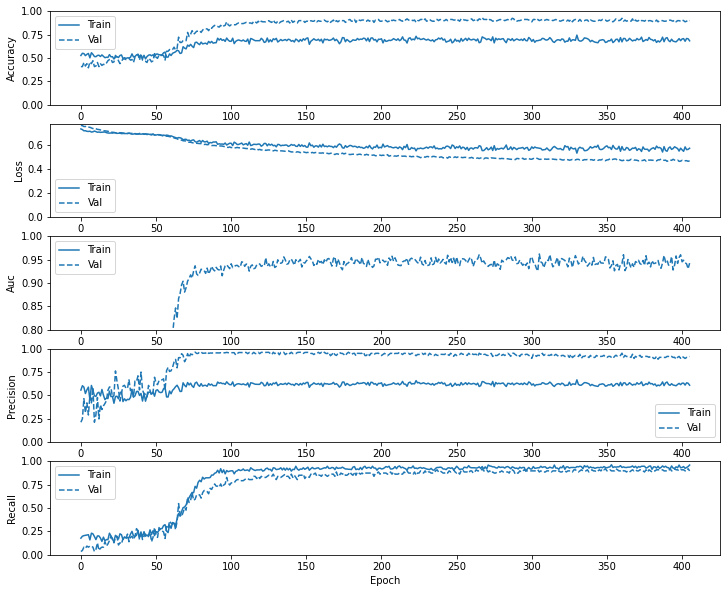

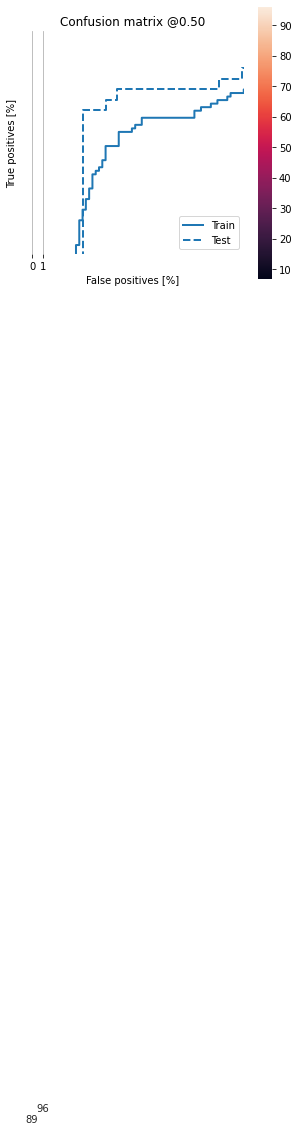

In [23]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1047s 81s/step - loss: 0.7119 - tp: 254.0000 - fp: 191.2143 - tn: 95.2857 - fn: 28.3571 - accuracy: 0.6417 - precision: 0.5985 - recall: 0.9037 - auc: 0.7665 - val_loss: 0.7188 - val_tp: 61.0000 - val_fp: 72.0000 - val_tn: 1.0000 - val_fn: 25.0000 - val_accuracy: 0.3899 - val_precision: 0.4586 - val_recall: 0.7093 - val_auc: 0.2920
Epoch 2/10000
13/13 [==============================] - 1047s 81s/step - loss: 0.7206 - tp: 149.7143 - fp: 190.7143 - tn: 1.2143 - fn: 28.2143 - accuracy: 0.4027 - precision: 0.4329 - recall: 0.8464 - auc: 0.4179 - val_loss: 0.7178 - val_tp: 62.0000 - val_fp: 72.0000 - val_tn: 1.0000 - val_fn: 24.0000 - val_accuracy: 0.3962 - val_precision: 0.4627 - val_recall: 0.7209 - val_auc: 0.2957
Epoch 3/10000
13/13 [==============================] - 1047s 81s/step - loss: 0.7235 - tp: 143.7857 - fp: 193.0000 - tn: 0.7857 - fn: 32.2857 - accuracy: 0.3844 - precision: 0.4178 - recall: 0.8265 - auc: 0.3784 - val_loss:

13/13 [==============================] - 1046s 80s/step - loss: 0.6967 - tp: 56.7857 - fp: 37.6429 - tn: 149.9286 - fn: 125.5000 - accuracy: 0.5648 - precision: 0.6253 - recall: 0.3250 - auc: 0.5354 - val_loss: 0.7093 - val_tp: 17.0000 - val_fp: 15.0000 - val_tn: 58.0000 - val_fn: 69.0000 - val_accuracy: 0.4717 - val_precision: 0.5312 - val_recall: 0.1977 - val_auc: 0.3561
Epoch 23/10000
13/13 [==============================] - 1045s 80s/step - loss: 0.6922 - tp: 58.4286 - fp: 33.8571 - tn: 154.5714 - fn: 123.0000 - accuracy: 0.5872 - precision: 0.6572 - recall: 0.3427 - auc: 0.5467 - val_loss: 0.7078 - val_tp: 16.0000 - val_fp: 15.0000 - val_tn: 58.0000 - val_fn: 70.0000 - val_accuracy: 0.4654 - val_precision: 0.5161 - val_recall: 0.1860 - val_auc: 0.3564
Epoch 24/10000
13/13 [==============================] - 1046s 80s/step - loss: 0.6954 - tp: 49.2857 - fp: 32.9286 - tn: 160.7857 - fn: 126.8571 - accuracy: 0.5644 - precision: 0.5997 - recall: 0.2880 - auc: 0.5142 - val_loss: 0.7093 

13/13 [==============================] - 1047s 81s/step - loss: 0.6883 - tp: 44.7143 - fp: 4.9286 - tn: 186.7143 - fn: 133.5000 - accuracy: 0.6306 - precision: 0.9078 - recall: 0.2657 - auc: 0.5490 - val_loss: 0.7096 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 74.0000 - val_accuracy: 0.5157 - val_precision: 0.8000 - val_recall: 0.1395 - val_auc: 0.3515
Epoch 65/10000
13/13 [==============================] - 1051s 81s/step - loss: 0.6872 - tp: 38.6429 - fp: 5.0000 - tn: 186.5714 - fn: 139.6429 - accuracy: 0.6049 - precision: 0.8689 - recall: 0.2089 - auc: 0.5759 - val_loss: 0.7081 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3752
Epoch 66/10000
13/13 [==============================] - 1053s 81s/step - loss: 0.6874 - tp: 47.7143 - fp: 4.6429 - tn: 188.0000 - fn: 129.5000 - accuracy: 0.6450 - precision: 0.9183 - recall: 0.2778 - auc: 0.5225 - val_loss: 0.7109 - val

13/13 [==============================] - 1049s 81s/step - loss: 0.6434 - tp: 57.2143 - fp: 2.2857 - tn: 185.5714 - fn: 124.7857 - accuracy: 0.6560 - precision: 0.9604 - recall: 0.3261 - auc: 0.6901 - val_loss: 0.7428 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.3883
Epoch 107/10000
13/13 [==============================] - 1050s 81s/step - loss: 0.6372 - tp: 56.7143 - fp: 4.4286 - tn: 184.5714 - fn: 124.1429 - accuracy: 0.6584 - precision: 0.9369 - recall: 0.3198 - auc: 0.6545 - val_loss: 0.7457 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.3844
Epoch 108/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.6426 - tp: 53.7857 - fp: 5.4286 - tn: 184.1429 - fn: 126.5000 - accuracy: 0.6525 - precision: 0.9111 - recall: 0.3113 - auc: 0.6616 - val_loss: 0.7498 - v

13/13 [==============================] - 1051s 81s/step - loss: 0.5878 - tp: 76.2857 - fp: 4.4286 - tn: 187.2143 - fn: 101.9286 - accuracy: 0.7047 - precision: 0.9339 - recall: 0.4172 - auc: 0.7769 - val_loss: 0.7143 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.5869
Epoch 149/10000
13/13 [==============================] - 1053s 81s/step - loss: 0.6050 - tp: 70.5714 - fp: 6.5714 - tn: 180.0714 - fn: 112.6429 - accuracy: 0.6641 - precision: 0.9016 - recall: 0.3745 - auc: 0.7334 - val_loss: 0.7032 - val_tp: 19.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 67.0000 - val_accuracy: 0.5597 - val_precision: 0.8636 - val_recall: 0.2209 - val_auc: 0.6277
Epoch 150/10000
13/13 [==============================] - 1051s 81s/step - loss: 0.5794 - tp: 70.1429 - fp: 5.3571 - tn: 191.2143 - fn: 103.1429 - accuracy: 0.7108 - precision: 0.9352 - recall: 0.4050 - auc: 0.7223 - val_loss: 0.7087 - v

13/13 [==============================] - 1049s 81s/step - loss: 0.5496 - tp: 91.0000 - fp: 8.7857 - tn: 188.3571 - fn: 81.7143 - accuracy: 0.7582 - precision: 0.9103 - recall: 0.5308 - auc: 0.7660 - val_loss: 0.5976 - val_tp: 45.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 41.0000 - val_accuracy: 0.7170 - val_precision: 0.9184 - val_recall: 0.5233 - val_auc: 0.9059
Epoch 191/10000
13/13 [==============================] - 1049s 81s/step - loss: 0.5298 - tp: 96.9286 - fp: 8.1429 - tn: 184.8571 - fn: 79.9286 - accuracy: 0.7681 - precision: 0.9196 - recall: 0.5628 - auc: 0.7921 - val_loss: 0.6022 - val_tp: 45.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 41.0000 - val_accuracy: 0.7170 - val_precision: 0.9184 - val_recall: 0.5233 - val_auc: 0.8742
Epoch 192/10000
13/13 [==============================] - 1047s 81s/step - loss: 0.5074 - tp: 105.7143 - fp: 4.0000 - tn: 190.3571 - fn: 69.7857 - accuracy: 0.8019 - precision: 0.9716 - recall: 0.5949 - auc: 0.8206 - val_loss: 0.6019 - val

13/13 [==============================] - 1049s 81s/step - loss: 0.5202 - tp: 97.6429 - fp: 9.3571 - tn: 187.8571 - fn: 75.0000 - accuracy: 0.7808 - precision: 0.9192 - recall: 0.5770 - auc: 0.7786 - val_loss: 0.5365 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9222
Epoch 233/10000
13/13 [==============================] - 1046s 80s/step - loss: 0.5499 - tp: 91.2143 - fp: 10.4286 - tn: 181.2143 - fn: 87.0000 - accuracy: 0.7372 - precision: 0.8965 - recall: 0.5053 - auc: 0.7438 - val_loss: 0.5348 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9317
Epoch 234/10000
13/13 [==============================] - 1046s 80s/step - loss: 0.5162 - tp: 102.9286 - fp: 7.4286 - tn: 186.0714 - fn: 73.4286 - accuracy: 0.7882 - precision: 0.9288 - recall: 0.5890 - auc: 0.7930 - val_loss: 0.5362 - va

13/13 [==============================] - 1048s 81s/step - loss: 0.4816 - tp: 103.6429 - fp: 8.4286 - tn: 190.2857 - fn: 67.5000 - accuracy: 0.8116 - precision: 0.9084 - recall: 0.6425 - auc: 0.7896 - val_loss: 0.5114 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9398
Epoch 275/10000
13/13 [==============================] - 1049s 81s/step - loss: 0.4900 - tp: 112.2143 - fp: 6.7857 - tn: 184.2857 - fn: 66.5714 - accuracy: 0.8102 - precision: 0.9480 - recall: 0.6436 - auc: 0.7892 - val_loss: 0.5093 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9388
Epoch 276/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.5235 - tp: 108.7143 - fp: 5.5714 - tn: 183.6429 - fn: 71.9286 - accuracy: 0.7831 - precision: 0.9523 - recall: 0.5881 - auc: 0.7793 - val_loss: 0.5039 - v

13/13 [==============================] - 1047s 81s/step - loss: 0.4885 - tp: 111.1429 - fp: 7.5714 - tn: 182.8571 - fn: 68.2857 - accuracy: 0.7837 - precision: 0.9308 - recall: 0.6097 - auc: 0.8073 - val_loss: 0.4897 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9437
Epoch 317/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.4644 - tp: 112.4286 - fp: 3.3571 - tn: 190.4286 - fn: 63.6429 - accuracy: 0.8281 - precision: 0.9748 - recall: 0.6506 - auc: 0.8225 - val_loss: 0.4877 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9405
Epoch 318/10000
13/13 [==============================] - 1047s 81s/step - loss: 0.4867 - tp: 106.0714 - fp: 4.4286 - tn: 190.2857 - fn: 69.0714 - accuracy: 0.8034 - precision: 0.9686 - recall: 0.6079 - auc: 0.8119 - val_loss: 0.4915 - v

13/13 [==============================] - 1046s 80s/step - loss: 0.4992 - tp: 102.2857 - fp: 5.7857 - tn: 185.2857 - fn: 76.5000 - accuracy: 0.7806 - precision: 0.9528 - recall: 0.5746 - auc: 0.7584 - val_loss: 0.4880 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9382
Epoch 359/10000
13/13 [==============================] - 1045s 80s/step - loss: 0.4766 - tp: 111.0714 - fp: 7.0000 - tn: 180.5000 - fn: 71.2857 - accuracy: 0.7866 - precision: 0.9459 - recall: 0.6043 - auc: 0.8060 - val_loss: 0.4731 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9462
Epoch 360/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.5287 - tp: 101.5714 - fp: 9.7857 - tn: 179.2143 - fn: 79.2857 - accuracy: 0.7561 - precision: 0.9110 - recall: 0.5563 - auc: 0.7536 - val_loss: 0.4763 - v

13/13 [==============================] - 1046s 80s/step - loss: 0.4991 - tp: 107.1429 - fp: 6.6429 - tn: 183.5714 - fn: 72.5000 - accuracy: 0.7737 - precision: 0.9368 - recall: 0.5861 - auc: 0.7697 - val_loss: 0.4711 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9364
Epoch 401/10000
13/13 [==============================] - 1048s 81s/step - loss: 0.4620 - tp: 107.5714 - fp: 6.3571 - tn: 187.2143 - fn: 68.7143 - accuracy: 0.8045 - precision: 0.9511 - recall: 0.6223 - auc: 0.8042 - val_loss: 0.4684 - val_tp: 65.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 21.0000 - val_accuracy: 0.8428 - val_precision: 0.9420 - val_recall: 0.7558 - val_auc: 0.9398
Epoch 402/10000
13/13 [==============================] - 1046s 80s/step - loss: 0.5060 - tp: 107.2143 - fp: 8.5714 - tn: 183.0000 - fn: 71.0714 - accuracy: 0.7707 - precision: 0.9168 - recall: 0.5822 - auc: 0.7591 - val_loss: 0.4735 - v

loss :  0.43005749583244324
tp :  82.0
fp :  2.0
tn :  94.0
fn :  21.0
accuracy :  0.8844221234321594
precision :  0.976190447807312
recall :  0.7961165308952332
auc :  0.9710760116577148

Legitimate Domain Name Detected (True Negatives):  94
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  2
Botnet DGA Missed (False Negatives):  19
Botnet DGA Detected (True Positives):  84
Total Botnet DGAs:  103
CPU times: user 5d 47min 15s, sys: 18min 24s, total: 5d 1h 5min 39s
Wall time: 5d 2h 19min 52s


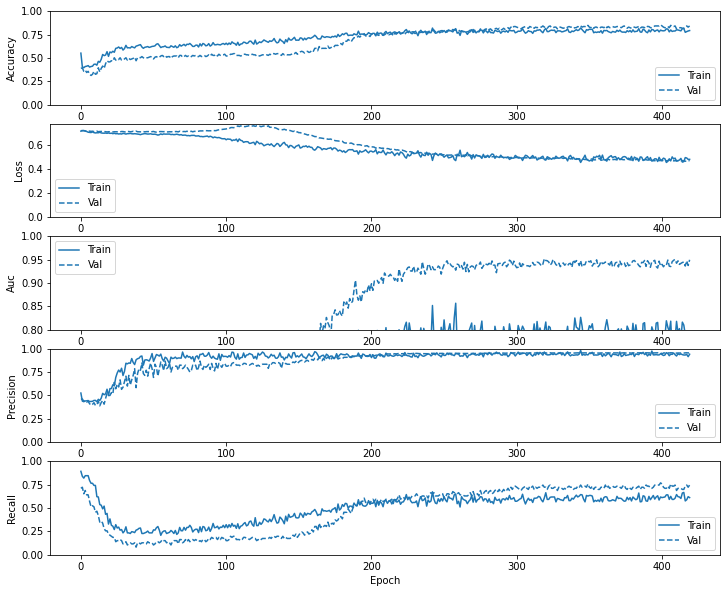

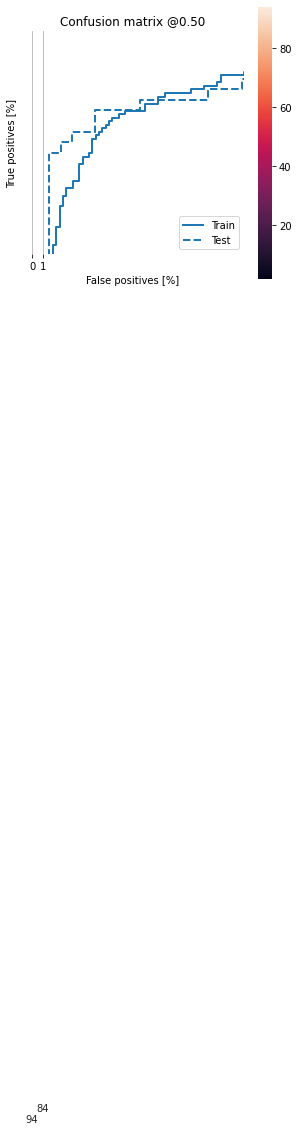

In [24]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [25]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [26]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_7 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 3s 87ms/step - loss: 0.7219 - tp: 135.5000 - fp: 15.0714 - tn: 271.4286 - fn: 146.8571 - accuracy: 0.7289 - precision: 0.9034 - recall: 0.5074 - auc: 0.7281 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.5277

13/13 [==============================] - 0s 11ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 5

13/13 [==============================] - 0s 9ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp:

13/13 [==============================] - 0s 11ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 13ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp:

13/13 [==============================] - 0s 11ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73

13/13 [==============================] - 0s 10ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 13ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 

13/13 [==============================] - 0s 12ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74

13/13 [==============================] - 0s 11ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.

13/13 [==============================] - 0s 10ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 1min 24s, sys: 3.43 s, total: 1min 27s
Wall time: 1min 19s


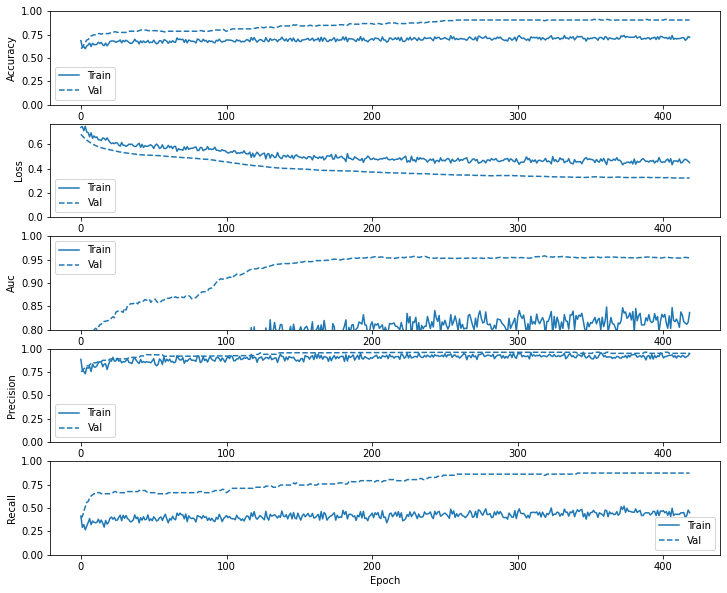

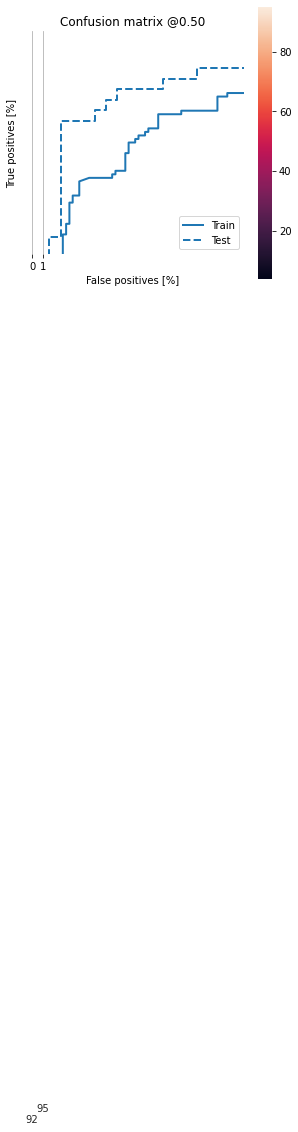

In [27]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [28]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_belem - qiskit.aer - seed 123")
f.flush()